# Расчётное задание 2b "Аппроксимация результатов измерений зависимых переменных"
- студент: Сыров Егор Романович
- группа: 5130901/30201

In [212]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator
from scipy.optimize import curve_fit
import warnings

warnings.filterwarnings("ignore")


# Считывание данных из файла
with open("Task_2b.txt", "r") as file:
    nx = int(file.readline().split("=")[1])
    ny = int(file.readline().split("=")[1])
    x = list(map(np.float64, file.readline().split("=", 1)[1].split()))
    y = []
    for line in file:
        y_i = list(map(np.float64, line.split("=", 1)[1].split()))
        y.append(y_i)

# Приводим к np.array для параллельных вычислений
x = np.array(x)
y = np.array(y)
df = pd.DataFrame(y, index=x, columns=[f"y_{i+1}" for i in range(ny)])
df

,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10
-2.0,-16.25280,-12.49660,7.29730,-1.044000,-23.13510,-4.91375,-38.86790,-1.71512,-29.99650,-8.76051
-1.9,-20.55480,-25.00250,-49.13580,-35.911300,-1.44807,-2.95197,-50.14930,-16.44190,-22.28700,-39.13680
-1.8,-58.14500,-31.38800,-47.13900,-52.170900,-36.60580,-60.95190,-48.92500,-49.29130,-24.92270,-41.46350
-1.7,-61.17980,-67.13150,-94.42240,-47.787500,-67.94720,-74.90080,-74.55220,-78.82430,-57.32470,-84.94240
-1.6,-59.11520,-107.44000,-55.41440,-106.930000,-48.29990,-60.90860,-82.65450,-80.99280,-90.16550,-68.63910
-1.5,-78.41000,-88.77780,-60.87250,-64.463400,-63.67370,-75.20020,-62.05220,-77.42470,-61.74030,-41.70070
-1.4,-69.56390,-51.53460,-97.38320,-62.444000,-69.00500,-68.26720,-67.38880,-80.12200,-67.74050,-66.75540
-1.3,-20.52090,-39.72000,-58.42640,-43.412200,-45.59140,-27.14040,-62.03190,-37.82690,-40.32290,-48.15950
-1.2,-24.31430,-33.43480,-10.88460,-37.963800,-13.34650,-15.08710,1.75719,-18.26120,-33.91410,-24.74440
-1.1,-36.89140,-2.36692,-8.26458,-14.640700,-9.20905,-10.93300,-22.00890,5.77602,-35.03000,2.10727


# Вычислить в каждой точке средние арифметические значения, оценки дисперсий, параметрические толерантные пределы для погрешностей, доверительные интервалы для математических ожиданий, проверить гипотезу о равенстве дисперсий в этих точках по критерию Кочрена (см. приложение 3)

In [213]:
means = np.mean(y, axis=1)
variances = np.var(y, axis=1, ddof=1)
std_devs = np.sqrt(variances)
# Относительное стандартное отклонение (коэффициенты вариации)
cv = std_devs / np.abs(means) * 100


# Доверительные интервалы для Математического Ожидания
confidence_level = 0.95
alpha = 1 - confidence_level

ci_lower = np.zeros(nx)
ci_upper = np.zeros(nx)

for i in range(nx):
    ci = stats.t.interval(
        confidence_level, df=ny - 1, loc=means[i], scale=std_devs[i] / np.sqrt(ny)
    )
    ci_lower[i], ci_upper[i] = ci

# Вычисление толерантных пределов
beta = 0.80  # Доля генеральной совокупности
gamma = 0.95  # Доверительная вероятность

# Вычисление толерантного множителя K для нормального распределения
# Используем аппроксимацию Хау (Howe) для больших n
# K = z_{(1+beta)/2} * sqrt((n-1) * (1 + 1/n) / chi2_{1-gamma, n-1})

z_beta = stats.norm.ppf((1 + beta) / 2)
chi2_gamma = stats.chi2.ppf(1 - gamma, df=ny - 1)

K = z_beta * np.sqrt((ny - 1) * (1 + 1 / ny) / chi2_gamma)

tolerance_lower = means - K * std_devs
tolerance_upper = means + K * std_devs

print(f"Толерантный множитель K = {K:.4f}")
print(f"Для первой точки (x={x[0]:.4f}):")
print(f"\tСреднее = {means[0]:.4f}")
print(f"\tСтандартное отклонение = {std_devs[0]:.4f}")
print(f"Толерантные пределы: [{tolerance_lower[0]:.4f}, {tolerance_upper[0]:.4f}]")

# Статистика Кочрена: G = max(s_i^2) / sum(s_i^2)
G = np.max(variances) / np.sum(variances)


# Критическое значение для критерия Кочрена
def cochran_critical(n_groups, n_obs, alpha=0.05):
    """
    Аппроксимация критического значения критерия Кочрена
    n_groups - количество групп (nx)
    n_obs - количество наблюдений в каждой группе (ny)
    """
    df = n_obs - 1
    F_crit = stats.f.ppf(1 - alpha, dfn=df, dfd=df * (n_groups - 1))
    return F_crit / (F_crit + n_groups - 1)


G_crit = cochran_critical(nx, ny, alpha=0.05)

print(f"\nКритерий Кочрена:")
print(f"  Статистика G = {G:.6f}")
print(f"  Критическое значение G_crit = {G_crit:.6f}")
print(
    f"  Гипотеза о равенстве дисперсий {'принимается' if G < G_crit else 'отвергается'} на уровне значимости 0.05"
)

Толерантный множитель K = 2.2113
Для первой точки (x=-2.0000):
	Среднее = -12.9885
	Стандартное отклонение = 14.2876
Толерантные пределы: [-44.5829, 18.6059]

Критерий Кочрена:
  Статистика G = 0.065226
  Критическое значение G_crit = 0.045481
  Гипотеза о равенстве дисперсий отвергается на уровне значимости 0.05


# Визуализация математичекого ожидания

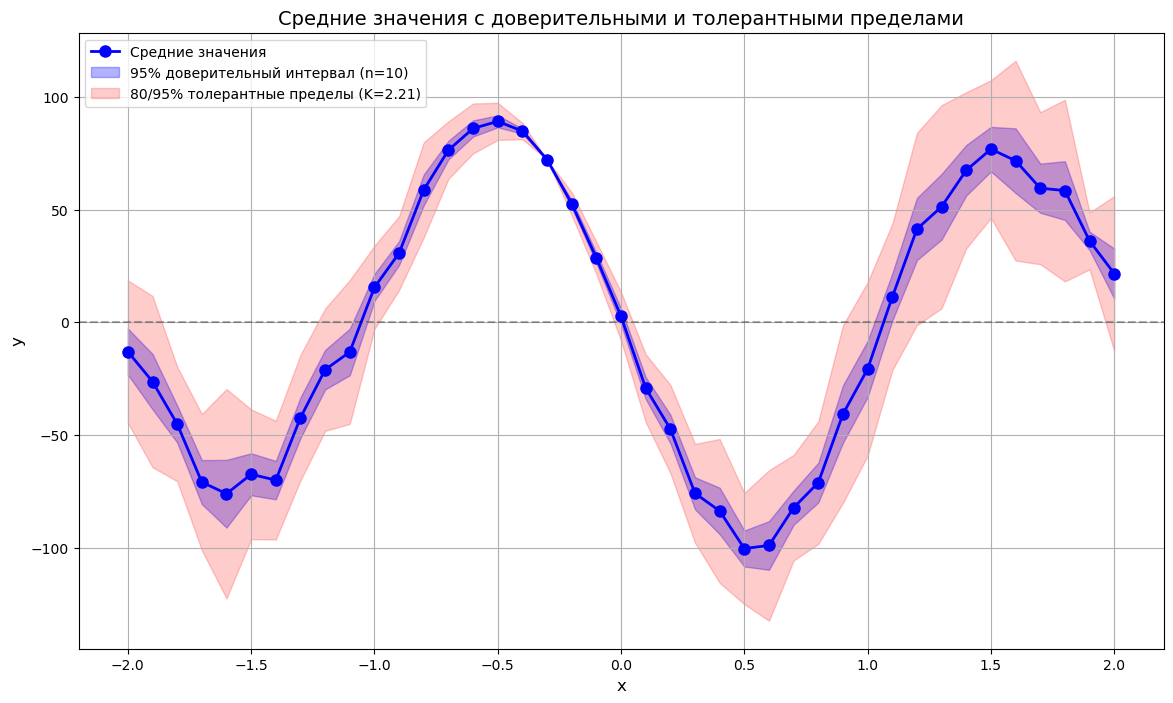

In [214]:
# Визуализация результатов
plt.figure(figsize=(14, 8))

# Средние значения
plt.plot(x, means, "bo-", linewidth=2, markersize=8, label="Средние значения")

# Доверительные интервалы для математических ожиданий
plt.fill_between(
    x,
    ci_lower,
    ci_upper,
    alpha=0.3,
    color="blue",
    label=f"95% доверительный интервал (n={ny})",
)

# Параметрические толерантные пределы
plt.fill_between(
    x,
    tolerance_lower,
    tolerance_upper,
    alpha=0.2,
    color="red",
    label=f"80/95% толерантные пределы (K={K:.2f})",
)

plt.grid()
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Средние значения с доверительными и толерантными пределами", fontsize=14)
plt.legend(fontsize=10)
plt.axhline(y=0, color="k", linestyle="--", alpha=0.3)

# Визуализация дисперсий и результат критерия Кочрена

Text(0.05, 0.8, 'Критерий Кочрена: G = 0.0652, G_crit = 0.0455\nГипотеза о равенстве дисперсий отвергается')

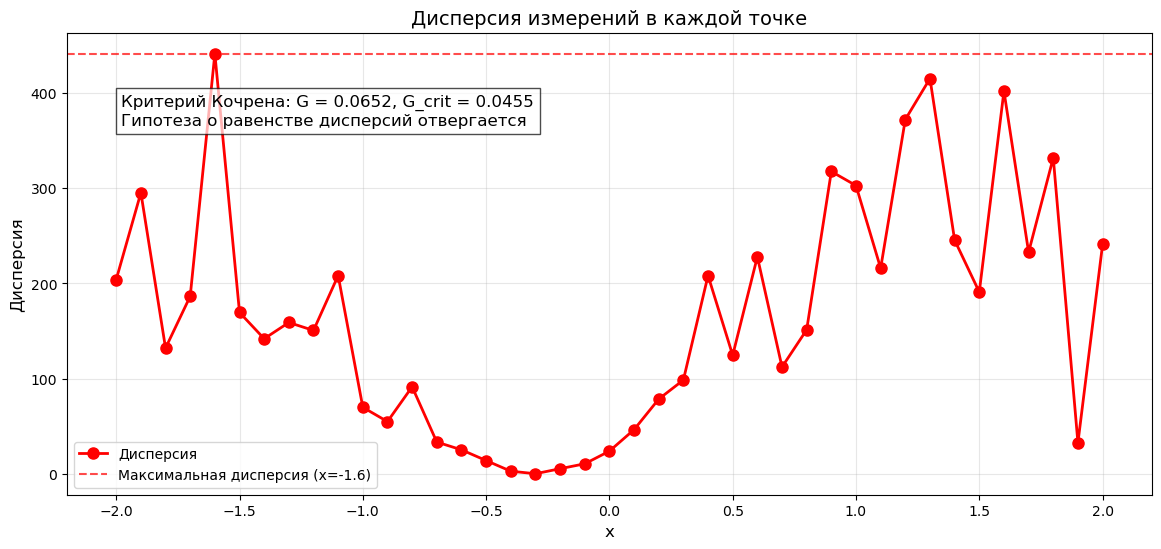

In [215]:
plt.figure(figsize=(14, 6))

plt.plot(x, variances, "ro-", linewidth=2, markersize=8, label="Дисперсия")
max_var_idx = np.argmax(variances)
plt.axhline(
    y=np.max(variances),
    color="r",
    linestyle="--",
    alpha=0.7,
    label=f"Максимальная дисперсия (x={x[max_var_idx]})",
)

plt.grid(True, alpha=0.3)
plt.xlabel("x", fontsize=12)
plt.ylabel("Дисперсия", fontsize=12)
plt.title("Дисперсия измерений в каждой точке", fontsize=14)
plt.legend(fontsize=10)

plt.text(
    0.05,
    0.80,
    f"Критерий Кочрена: G = {G:.4f}, G_crit = {G_crit:.4f}\n"
    f"Гипотеза о равенстве дисперсий "
    f'{"принимается" if G < G_crit else "отвергается"}',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.7),
)

# Тепловая карта корреляций между точками

[[ 1.         -0.02442697 -0.38356399 ...  0.22511334  0.48978497
   0.09546305]
 [-0.02442697  1.         -0.00981815 ...  0.22156875 -0.01413118
   0.73317554]
 [-0.38356399 -0.00981815  1.         ... -0.02060997 -0.18120288
   0.10785253]
 ...
 [ 0.22511334  0.22156875 -0.02060997 ...  1.          0.58429506
   0.41851193]
 [ 0.48978497 -0.01413118 -0.18120288 ...  0.58429506  1.
   0.26090394]
 [ 0.09546305  0.73317554  0.10785253 ...  0.41851193  0.26090394
   1.        ]]


<Axes: >

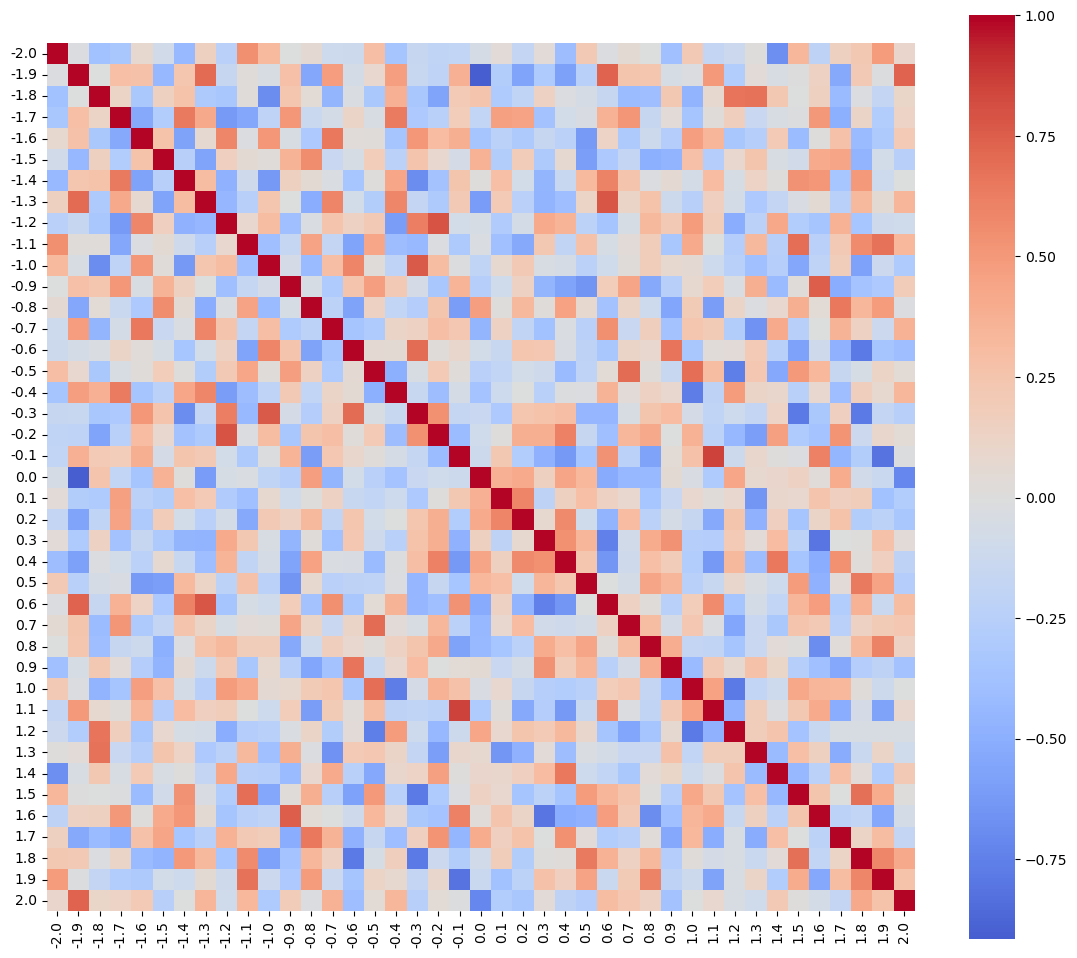

In [216]:
correlation_matrix = np.corrcoef(y)

print(correlation_matrix)

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    xticklabels=np.round(x, 2),
    yticklabels=np.round(x, 2),
    cmap="coolwarm",
    center=0,
    annot=False,
    square=True,
)

# Анализ тепловой карты корреляции
Полученный график коррелированности говорит о том, что данные слабо коррилированны - линейная связь отсутствует

# Произвести последовательную полиномиальную аппроксимацию Прим. В качестве значений y при аппроксимации необходимо использовать средние арифметические значения.

Коэффициент нулевой степени (константа): -0.0506
Коэффициенты линейной модели: a = 14.0425, b = -0.0506
Степень 0: остаточная дисперсия = 3646.5968
Степень 1: остаточная дисперсия = 3449.8738
Степень 2: остаточная дисперсия = 3536.5973
Степень 3: остаточная дисперсия = 2810.8266
Степень 4: остаточная дисперсия = 2888.8045
Степень 5: остаточная дисперсия = 455.8899


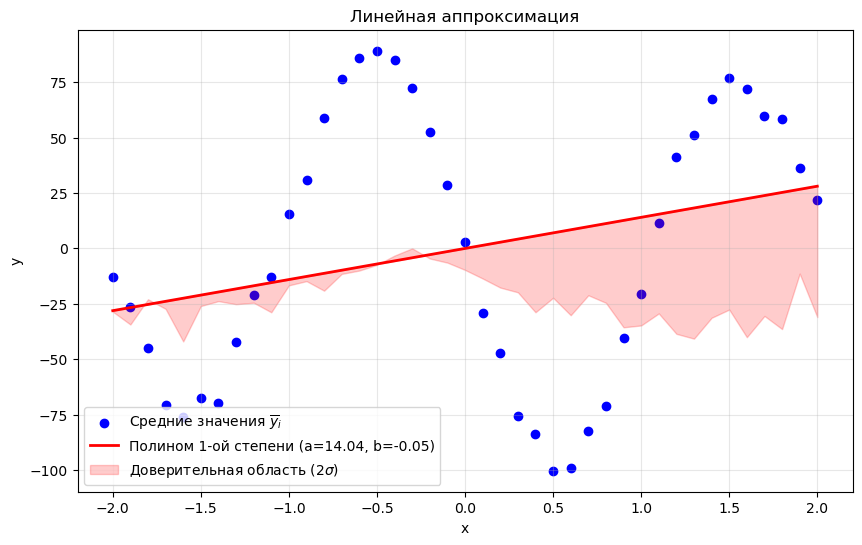

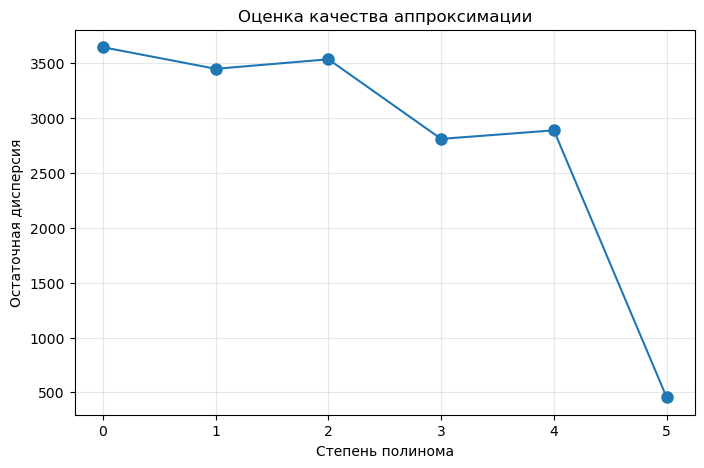

In [217]:
use_weighted = G <= G_crit


def polynomial_approximation(x, y, variances, degree, use_weighted):
    """
    Возвращает коэффициенты полинома для заданной степени.

    Аргументы:
        x: координаты точек
        y: средние значения y
        variances: дисперсии в каждой точке
        degree: степень полинома
        use_weighted: использовать взвешенный МНК (если дисперсии неравные)
    """
    X = np.vander(x, degree + 1)
    if use_weighted:
        weights = 1 / variances
        W = np.diag(weights)
        coeffs = np.linalg.solve(X.T @ W @ X, X.T @ W @ y)
    else:
        coeffs = np.linalg.solve(X.T @ X, X.T @ y)
    return coeffs


coeffs_0 = polynomial_approximation(x, means, variances, 0, use_weighted)
y_poly_0 = np.full_like(x, coeffs_0[0])

print(f"Коэффициент нулевой степени (константа): {coeffs_0[0]:.4f}")

# Первая степень (линейная модель: y = ax + b)
coeffs_1 = polynomial_approximation(x, means, variances, 1, use_weighted)
y_poly_1 = np.polyval(coeffs_1, x)

print(f"Коэффициенты линейной модели: a = {coeffs_1[0]:.4f}, b = {coeffs_1[1]:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(x, means, color="blue", label="Средние значения $\\overline{y}_i$")
plt.plot(
    x,
    y_poly_1,
    "r-",
    linewidth=2,
    label=f"Полином 1-ой степени (a={coeffs_1[0]:.2f}, b={coeffs_1[1]:.2f})",
)
plt.fill_between(
    x,
    y_poly_1,
    -2 * np.sqrt(variances),
    y_poly_1 + 2 * np.sqrt(variances),
    alpha=0.2,
    color="red",
    label="Доверительная область (2$\\sigma$)",
)
plt.grid(True, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Линейная аппроксимация")
plt.legend()


# Подбор оптимальной степени полинома
def residual_variances(x, y, coeffs, degree):
    y_pred = np.polyval(coeffs, x)
    residuals = y - y_pred
    return np.var(residuals, ddof=degree + 1)


degrees = np.arange(6)
residual_vars = []

for d in degrees:
    coeffs = polynomial_approximation(x, means, variances, d, use_weighted)
    res_var = residual_variances(x, means, coeffs, d)
    residual_vars.append(res_var)
    print(f"Степень {d}: остаточная дисперсия = {res_var:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(degrees, residual_vars, "o-", markersize=8)
plt.xlabel("Степень полинома")
plt.ylabel("Остаточная дисперсия")
plt.title("Оценка качества аппроксимации")
plt.grid(True, alpha=0.3)

После проведения оценки качества аппроксимации можно сделать вывод о том, чтоюы описать синусоиду необходим полином гораздо большей степени (>> 6).

# Подбор оптимальной степени полинома с помощью критерия Фишера

Степень q = 0: F= 0.0000, F_crit = 3.8643, R2 = 0.0000
Гипотеза о степени q = 0 НЕ отвергается. Оптимальная степень: 0


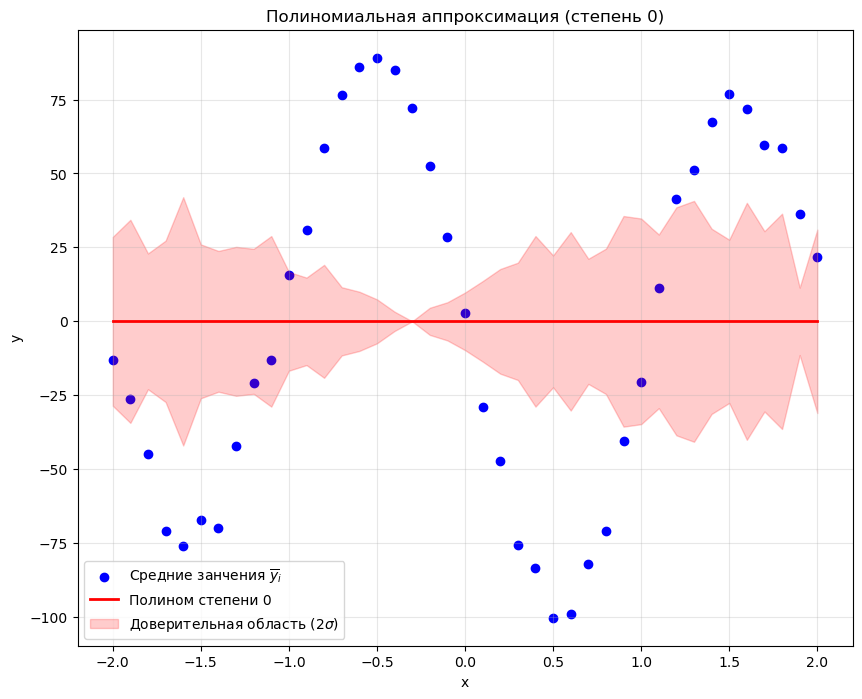

In [218]:
def calculate_f_statistic(x, y, q, nx, ny):
    """
    Вычисляет F-статистику для проверки гипотезы о степени полинома q.

    Аргументы:
        x: координаты точек (x_vals)
        y: средние значения (y_mean)
        q: текущая степень полинома
        nx: количество точек (41)
        ny: количество измерений в каждой точке (10)

    Возвращает:
        F: F-статистика
        F_crit: критическое значение F-распределения
        R2: коэффициент детерминации
    """

    # Построение полиномиальной модели
    coeffs = np.polyfit(x, y, q)
    y_pred = np.polyval(coeffs, x)

    # Общая сумма квадратов (SST)
    y_mean_global = np.mean(y)
    SST = np.sum((y - y_mean_global) ** 2)

    # Остаточная сумма квадратов (SSE)
    SSE = np.sum((y - y_pred) ** 2)

    # Коэффициент детерминаци
    R2 = 1 - SSE / SST

    # Выбор формулы для F-статичтики
    if ny > nx - q - 1:
        numerator = ny - nx + q + 1
        denominator = (ny - q - q) * (ny - 1)
        F = (numerator / denominator) * R2
    else:
        F = R2 / (nx - q - 1)

    # Критическое значение F-распределения
    # df1 = 1 (увеличение степени на 1), df2 = nx * ny - (q + 1)
    df1 = 1
    df2 = nx * ny - (q + 1)
    F_crit = stats.f.ppf(0.95, df1, df2)

    return F, F_crit, R2


def find_optimal_polinomial_degree(x, y, nx, ny, max_degree=10):
    """
    Находит оптимальную степень полинома, проверяя гипотезу для q = 0, 1, ..., max_degree.

    Возвращает:
        optimal_q: оптимальная степень
        F_values: список F-статистик для каждой степени
    """
    q = 0
    F_values = []
    optimal_q = None

    while q <= max_degree:
        F, F_crit, R2 = calculate_f_statistic(x, y, q, nx, ny)
        F_values.append(F)

        print(f"Степень q = {q}: F= {F:.4f}, F_crit = {F_crit:.4f}, R2 = {R2:.4f}")

        # Если гипотеза НЕ отвергается (F <= F_crit) - останавливаемся
        if F <= F_crit:
            optimal_q = q
            print(
                f"Гипотеза о степени q = {q} НЕ отвергается. Оптимальная степень: {q}"
            )
            break
        else:
            print(f"Гипотеза о степени q = {q} отвергается. Увеличиваем степень.")
            q += 1

    if optimal_q is None:
        optimal_q = max_degree
        print(
            f"Достигнута максимальная степень {max_degree}. Оптимальная степень: {optimal_q}"
        )

    return optimal_q, F_values


optimal_q, F_values = find_optimal_polinomial_degree(x, means, nx, ny, max_degree=10)

# Построение оптимальной модели
coeffs_opt = np.polyfit(x, means, optimal_q)
y_opt = np.polyval(coeffs_opt, x)

plt.figure(figsize=(10, 8))
plt.scatter(x, means, color="blue", label="Средние занчения $\\overline{y}_i$")
plt.plot(x, y_opt, "r-", linewidth=2, label=f"Полином степени {optimal_q}")
plt.fill_between(
    x,
    y_opt - 2 * np.sqrt(variances),
    y_opt + 2 * np.sqrt(variances),
    alpha=0.2,
    color="red",
    label="Доверительная область ($2\\sigma$)",
)
plt.grid(True, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Полиномиальная аппроксимация (степень {optimal_q})")
plt.legend()

Полиномиальная аппроксимация не может должным образом (см. Критерий Фишера) обесепчить аппроксимацию. Так как повышение степени полинома не добавляет результату аппроксимации точности - алгоритм поиска оптимальной степени полинома останавливается на нулевой степени. Для описания синусоиды нудно использовать более сложные способы аппроксимации (например Сплайны, или среднеквадратическую аппроксимацию).

# Вычислить корреляционную матрицу и коэффициенты корреляции между оценками коэффициентов по матрице ковариации

In [219]:
def calculate_covariance_matrix(x, y, q, use_weighted=False, weights=None):
    X = np.vander(x, q + 1)

    if use_weighted and weights is not None:
        W = np.diag(weights)
        XTWX = X.T @ W @ X
        sigma2 = 1.0
        Sa = np.linalg.inv(XTWX) * sigma2
    else:
        XTX = X.T @ X
        y_pred = np.polyval(np.polyfit(x, y, q), x)
        residuals = y - y_pred
        sigma2 = np.sum(residuals**2) / (len(x) - q - 1)
        Sa = np.linalg.inv(XTX) * sigma2

    return Sa


Sa = calculate_covariance_matrix(x, means, optimal_q)
print(f"Ковариационная матрица S_a (размер {optimal_q+1}x{optimal_q+1}):\n", Sa)

Ковариационная матрица S_a (размер 1x1):
 [[88.94138551]]


# Пусть была получена степень q полинома, прошедшая гипотезу о степени полинома. Произвести все те же действия для полинома степени, равной k-1 (вычислить коэффициенты и корреляцию между ними). Сравнить результаты для степени q и k-1 (качество аппроксимации, корреляционная матрица коэффициентов, матрица ковариации исходных данных и ее обусловленность).

Остаточная дисперсия для степени q = 0: 3740.0993
Остаточная дисперсия для степени k-1: 8.8667e+01 (теоретически 0)
Число обусловленности для степени q = 0: 1.00e+00
Число обусловленности для степени k-1: 2.35e+19


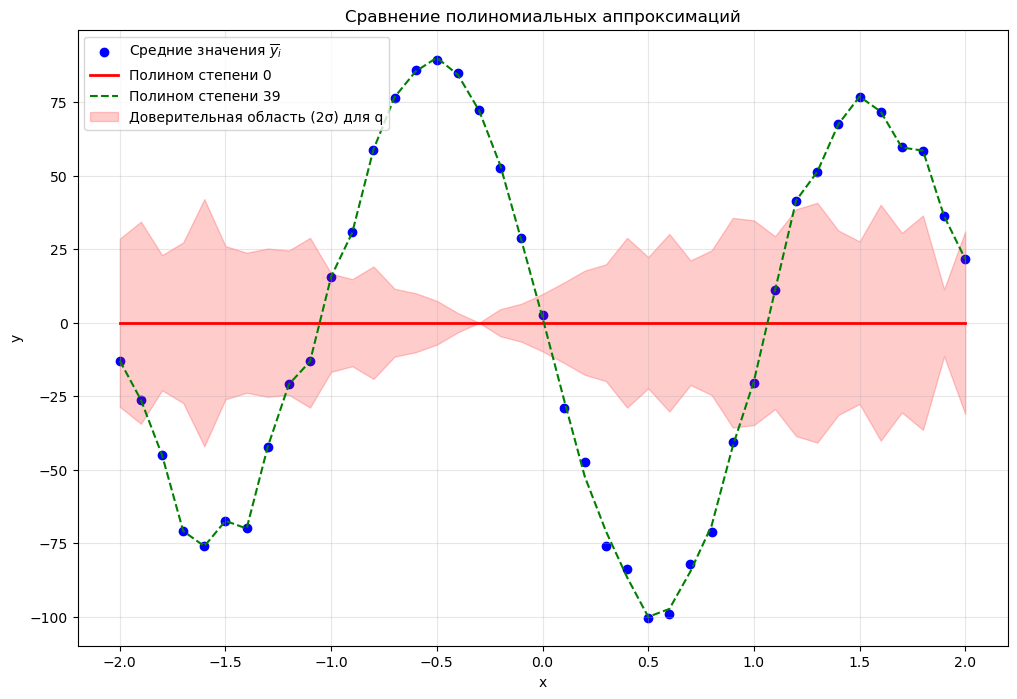

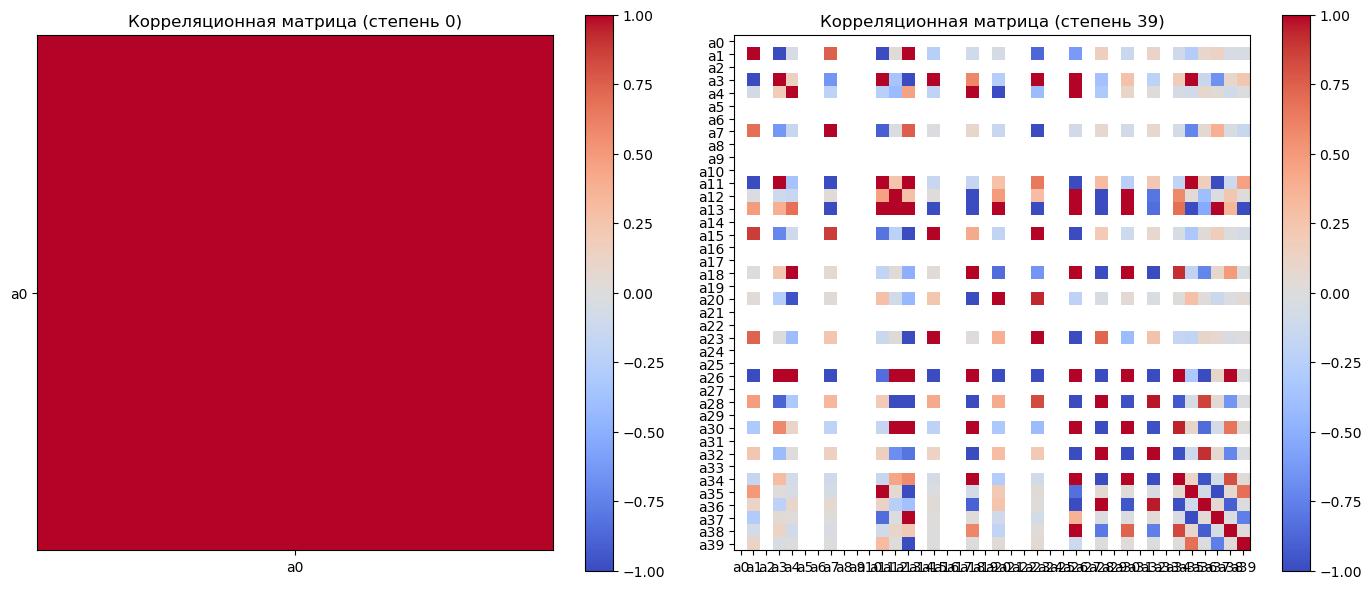

In [220]:
k = nx - 1
coeffs_k1 = np.polyfit(x, means, k)
y_k1 = np.polyval(coeffs_k1, x)
residuals_k1 = means - y_k1

# Для полинома степени q
residuals_q = means - y_opt  # где y_opt - значения полинома степени q
residual_var_q = np.sum(residuals_q**2) / (k - optimal_q - 1)

# Для полинома степени k-1
residual_var_k1 = np.sum(residuals_k1**2) / (
    k - (k - 1) - 1
)  # Деление на 0 - особый случай

# В случае k-1 степени полином точно проходит через все точки
# Поэтому остаточная дисперсия должна быть близка к нулю
print(f"Остаточная дисперсия для степени q = {optimal_q}: {residual_var_q:.4f}")
print(
    f"Остаточная дисперсия для степени k-1: {np.sum(residuals_k1**2):.4e} (теоретически 0)"
)

plt.figure(figsize=(12, 8))
plt.scatter(x, means, color="blue", label="Средние значения $\\overline{y}_i$")

# Полином степени q
plt.plot(x, y_opt, "r-", linewidth=2, label=f"Полином степени {optimal_q}")

# Полином степени k-1
plt.plot(x, y_k1, "g--", linewidth=1.5, label=f"Полином степени {k-1}")

plt.fill_between(
    x,
    y_opt - 2 * np.sqrt(variances),
    y_opt + 2 * np.sqrt(variances),
    alpha=0.2,
    color="red",
    label="Доверительная область (2σ) для q",
)

plt.grid(True, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Сравнение полиномиальных аппроксимаций")
plt.legend()


# Корреляционная матрица
# Для полинома степени q
cov_q = calculate_covariance_matrix(x, means, optimal_q)
cond_q = np.linalg.cond(cov_q)

# Для полинома степени k-1
cov_k1 = calculate_covariance_matrix(x, means, k - 1)
cond_k1 = np.linalg.cond(cov_k1)

print(f"Число обусловленности для степени q = {optimal_q}: {cond_q:.2e}")
print(f"Число обусловленности для степени k-1: {cond_k1:.2e}")


# Коррреляционная матрица коэффициентов
def get_correlation_matrix(cov_matrix):
    stds = np.sqrt(np.diag(cov_matrix))
    corr = cov_matrix / np.outer(stds, stds)
    return corr


# Корреляционные матрицы
corr_q = get_correlation_matrix(cov_q)
corr_k1 = get_correlation_matrix(cov_k1)

# Визуализация корреляционных матриц
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(corr_q, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title(f"Корреляционная матрица (степень {optimal_q})")
plt.xticks(range(optimal_q + 1), [f"a{i}" for i in range(optimal_q + 1)])
plt.yticks(range(optimal_q + 1), [f"a{i}" for i in range(optimal_q + 1)])

plt.subplot(1, 2, 2)
plt.imshow(corr_k1, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title(f"Корреляционная матрица (степень {k-1})")
plt.xticks(range(k), [f"a{i}" for i in range(k)])
plt.yticks(range(k), [f"a{i}" for i in range(k)])

plt.tight_layout()

# Аппроксимация другими способами

## Линейная регрессия

In [221]:
X = x.reshape(-1, 1)
model_linear = LinearRegression()
model_linear.fit(X, means)
y_pred_linear = model_linear.predict(X)

r2_linear = r2_score(means, y_pred_linear)
mse_linear = mean_squared_error(means, y_pred_linear)
coeffs_linear = model_linear.coef_[0], model_linear.intercept_

print(f"Linear Regression: R² = {r2_linear:.4f}, MSE = {mse_linear:.4f}")
print(f"Коэффициенты: a = {coeffs_linear[0]:.4f}, b = {coeffs_linear[1]:.4f}")

Linear Regression: R² = 0.0776, MSE = 3281.5872
Коэффициенты: a = 14.0425, b = -0.0506


## Robust Regression (Робастная регрессия)

In [222]:
X_sm = sm.add_constant(x)
model_robust = sm.RLM(means, X_sm, M=sm.robust.norms.HuberT())
results_robust = model_robust.fit()
y_pred_robust = results_robust.predict(X_sm)

# Метрики
r2_robust = r2_score(means, y_pred_robust)
mse_robust = mean_squared_error(means, y_pred_robust)
coeffs_robust = results_robust.params

print(f"Robust Regression: R² = {r2_robust:.4f}, MSE = {mse_robust:.4f}")
print(f"Коэффициенты: a = {coeffs_robust[1]:.4f}, b = {coeffs_robust[0]:.4f}")

Robust Regression: R² = 0.0774, MSE = 3282.1459
Коэффициенты: a = 14.3576, b = 0.5972


## Polyfit (полиномиальная регрессия с n = 1)

In [223]:
coeffs_poly = np.polyfit(x, means, 1)
y_pred_poly = np.polyval(coeffs_poly, x)

r2_poly = r2_score(means, y_pred_poly)
mse_poly = mean_squared_error(means, y_pred_poly)

print(f"Polyfit: R² = {r2_poly:.4f}, MSE = {mse_poly:.4f}")
print(f"Коэффициенты: a = {coeffs_poly[0]:.4f}, b = {coeffs_poly[1]:.4f}")

Polyfit: R² = 0.0776, MSE = 3281.5872
Коэффициенты: a = 14.0425, b = -0.0506


## Ridge Regression (ридж-регрессия)

In [224]:
# Ридж-регрессия
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X, means)
y_pred_ridge = model_ridge.predict(X)

# Метрики
r2_ridge = r2_score(means, y_pred_ridge)
mse_ridge = mean_squared_error(means, y_pred_ridge)
coeffs_ridge = model_ridge.coef_[0], model_ridge.intercept_

print(f"Ridge Regression: R² = {r2_ridge:.4f}, MSE = {mse_ridge:.4f}")
print(f"Коэффициенты: a = {coeffs_ridge[0]:.4f}, b = {coeffs_ridge[1]:.4f}")

Ridge Regression: R² = 0.0776, MSE = 3281.6682
Коэффициенты: a = 13.8020, b = -0.0506


## Визуализация результатов линейной аппроксимации

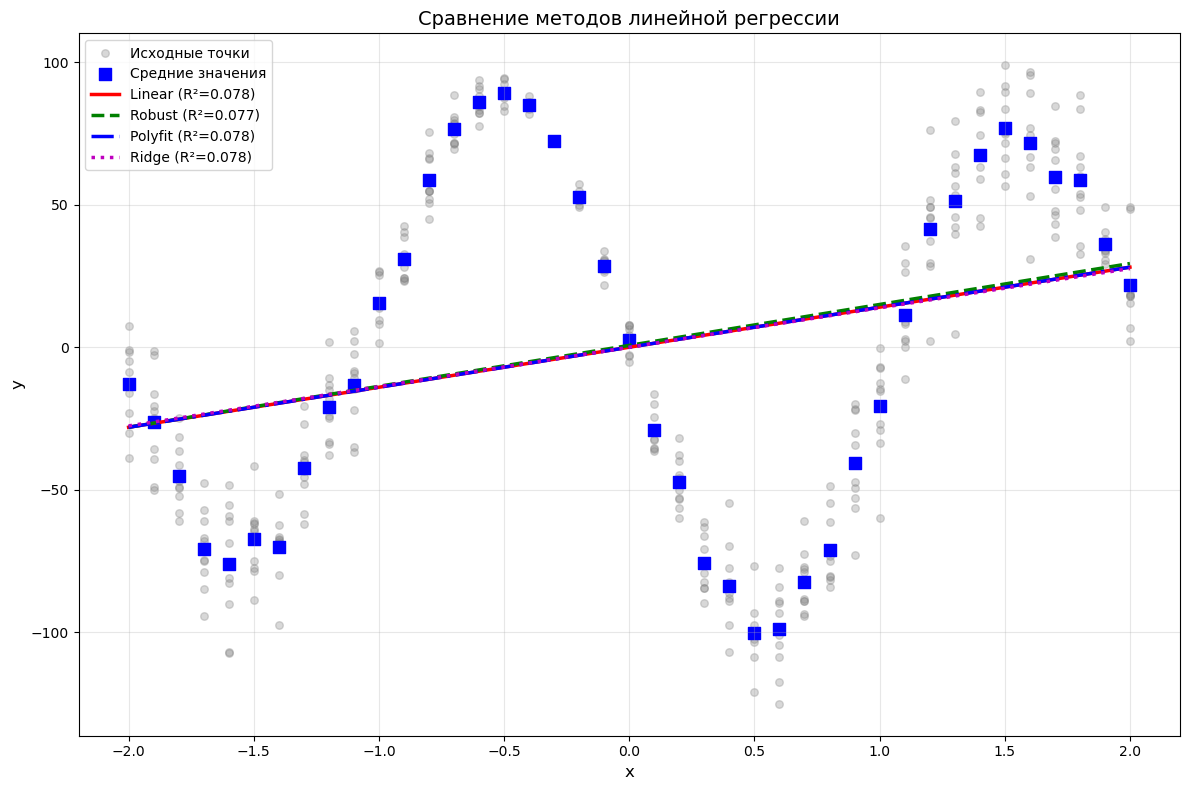

In [225]:
plt.figure(figsize=(12, 8))

for i in range(10):
    plt.scatter(
        x,
        y[:, i],
        color="gray",
        alpha=0.3,
        s=30,
        label="Исходные точки" if i == 0 else "",
    )
plt.scatter(x, means, color="blue", marker="s", s=80, label="Средние значения")

# Отображение аппроксимирующих прямых
plt.plot(x, y_pred_linear, "r-", linewidth=2.5, label=f"Linear (R²={r2_linear:.3f})")
plt.plot(x, y_pred_robust, "g--", linewidth=2.5, label=f"Robust (R²={r2_robust:.3f})")
plt.plot(x, y_pred_poly, "b-.", linewidth=2.5, label=f"Polyfit (R²={r2_poly:.3f})")
plt.plot(x, y_pred_ridge, "m:", linewidth=2.5, label=f"Ridge (R²={r2_ridge:.3f})")

plt.grid(True, alpha=0.3)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Сравнение методов линейной регрессии", fontsize=14)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Полиномиальная аппроксимация

In [226]:
degrees = [1, 2, 3, 4, 5, 10, 20, 30, 40]
results_poly = []
for deg in degrees:
    coeffs = np.polyfit(x, means, deg)
    y_pred = np.polyval(coeffs, x)
    r2 = r2_score(means, y_pred)
    mse = mean_squared_error(means, y_pred)
    results_poly.append((deg, r2, mse, coeffs, y_pred))

    print(f"Степень {deg}: R² = {r2:.4f}, MSE = {mse:.4f}")

Степень 1: R² = 0.0776, MSE = 3281.5872
Степень 2: R² = 0.0787, MSE = 3277.8219
Степень 3: R² = 0.2870, MSE = 2536.5996
Степень 4: R² = 0.2870, MSE = 2536.5112
Степень 5: R² = 0.8906, MSE = 389.1743
Степень 10: R² = 0.9956, MSE = 15.7857
Степень 20: R² = 0.9972, MSE = 9.7958
Степень 30: R² = 0.9987, MSE = 4.5696
Степень 40: R² = 0.9994, MSE = 2.1626


## Визуализация полиномиальных аппроксимаций

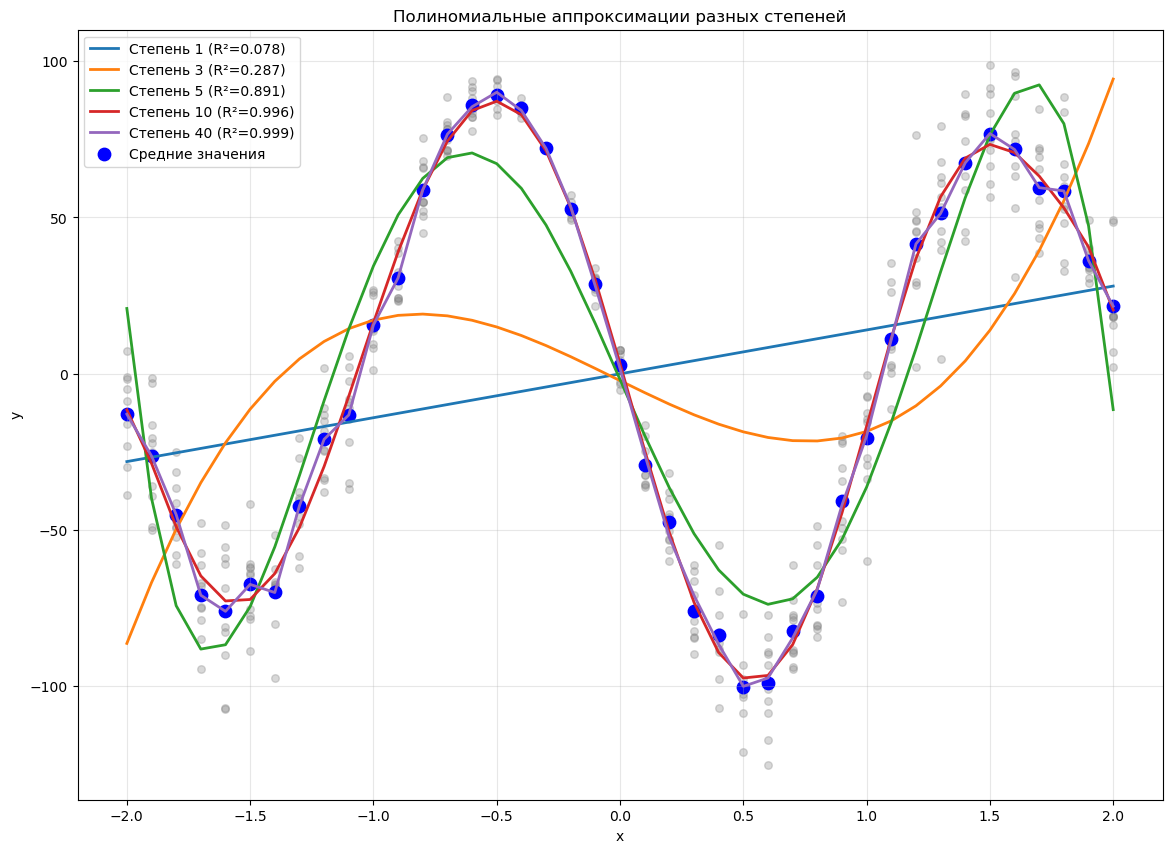

In [227]:
plt.figure(figsize=(14, 10))
for i, (deg, r2, mse, coeffs, y_pred) in enumerate(results_poly):
    if deg in [1, 3, 5, 10, 40]:
        plt.plot(x, y_pred, linewidth=2, label=f"Степень {deg} (R²={r2:.3f})")

# Исходные данные
for i in range(10):
    plt.scatter(x, y[:, i], color="gray", alpha=0.3, s=30)
plt.scatter(x, means, color="blue", s=80, label="Средние значения")

plt.grid(True, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Полиномиальные аппроксимации разных степеней")
plt.legend()

# Кусочная полиномиальная аппроксимация

In [228]:
# Линейная интерполяция
f_linear = interp1d(x, means, kind="linear")
x_fine = np.linspace(min(X), max(x), 500)
y_linear = f_linear(x_fine)

# Кубическая интерполяция
f_cubic = interp1d(x, means, kind="cubic")
y_cubic = f_cubic(x_fine)

# PCHIP (полиномы Эрмита)
f_pchip = PchipInterpolator(x, means)
y_pchip = f_pchip(x_fine)

# Сплайны
spline = CubicSpline(x, means)
y_spline = spline(x_fine)

## Визуализация

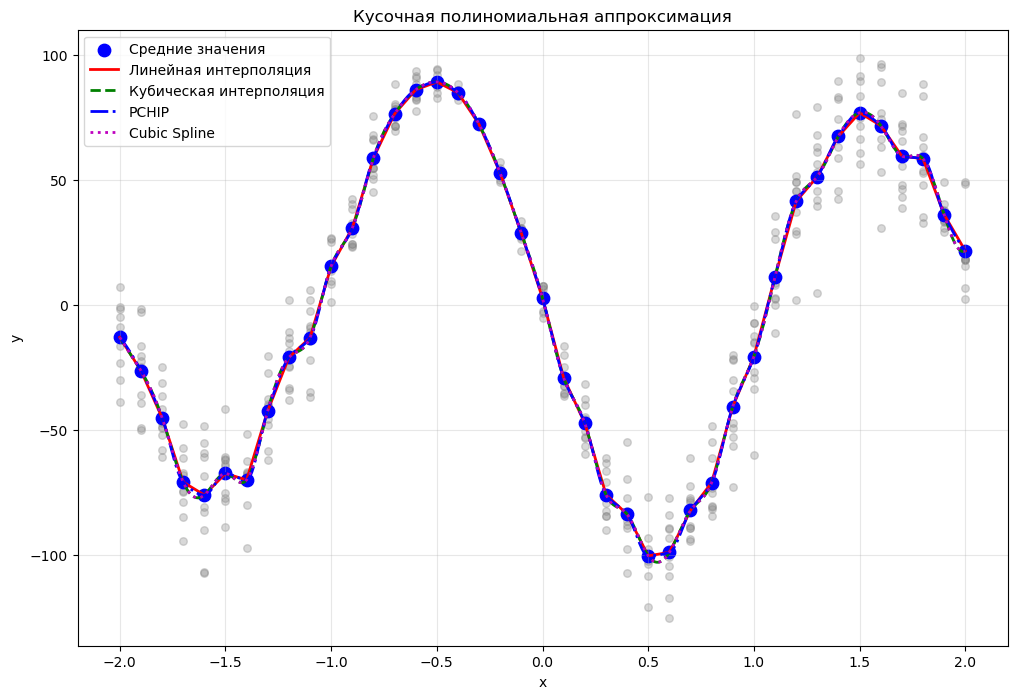

In [229]:
plt.figure(figsize=(12, 8))

# Отображение исходных данных
for i in range(10):
    plt.scatter(x, y[:, i], color="gray", alpha=0.3, s=30)
plt.scatter(x, means, color="blue", s=80, label="Средние значения")

# Отображение различных методов интерполяции
plt.plot(x_fine, y_linear, "r-", linewidth=2, label="Линейная интерполяция")
plt.plot(x_fine, y_cubic, "g--", linewidth=2, label="Кубическая интерполяция")
plt.plot(x_fine, y_pchip, "b-.", linewidth=2, label="PCHIP")
plt.plot(x_fine, y_spline, "m:", linewidth=2, label="Cubic Spline")

plt.grid(True, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Кусочная полиномиальная аппроксимация")
plt.legend()

# Нелинейная аппроксимация

In [230]:
def nonlinear_func(x, a0, a1, a2, beta):
    """y(x) = (sin(x) + β)(a2*x^2 + a1*x + a0)"""
    return (np.sin(x) + beta) * (a2 * x**2 + a1 * x + a0)


# Начальные приближения параметров
initial_guess = [1, 1, 1, 1]

# Нелинейная регрессия
params, covariance = curve_fit(nonlinear_func, x, means, p0=initial_guess)
y_pred_nonlinear = nonlinear_func(x, *params)

# Метрики
r2_nonlinear = r2_score(means, y_pred_nonlinear)
mse_nonlinear = mean_squared_error(means, y_pred_nonlinear)

print(f"Нелинейная регрессия: R² = {r2_nonlinear:.4f}, MSE = {mse_nonlinear:.4f}")
print(
    f"Параметры: a0={params[0]:.4f}, a1={params[1]:.4f}, a2={params[2]:.4f}, beta={params[3]:.4f}"
)

Нелинейная регрессия: R² = 0.4643, MSE = 1905.8547
Параметры: a0=-80.3604, a1=0.3627, a2=45.8674, beta=0.0292


## Визуализация

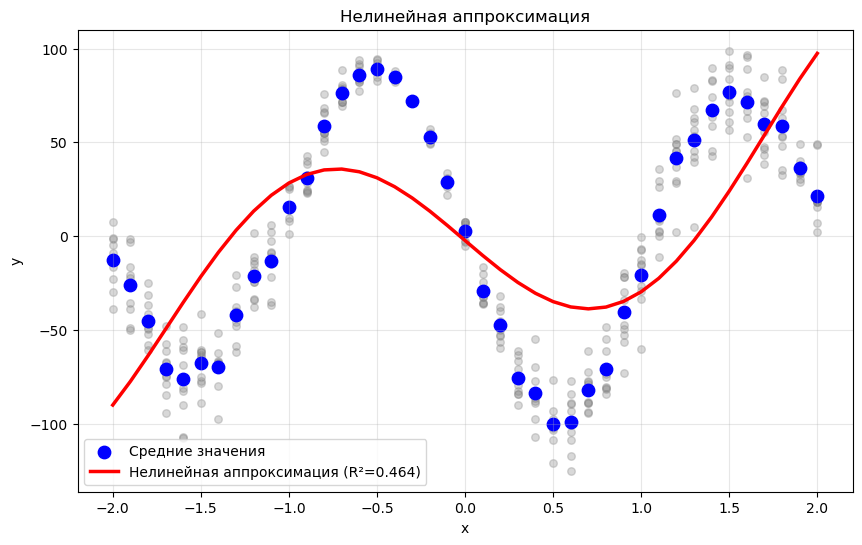

In [231]:
plt.figure(figsize=(10, 6))

# Отображение исходных данных
for i in range(10):
    plt.scatter(x, y[:, i], color="gray", alpha=0.3, s=30)
plt.scatter(x, means, color="blue", s=80, label="Средние значения")

# Отображение нелинейной аппроксимации
plt.plot(
    x,
    y_pred_nonlinear,
    "r-",
    linewidth=2.5,
    label=f"Нелинейная аппроксимация (R²={r2_nonlinear:.3f})",
)

plt.grid(True, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Нелинейная аппроксимация")
plt.legend()

# Выводы

In [233]:
# Сбор результатов в таблицу
results = []

# Линейные методы
results.append(
    (
        "Linear Regression",
        r2_linear,
        mse_linear,
        "Низкая",
        "Средняя",
        "Чувствителен к выбросам",
    )
)
results.append(
    (
        "Robust Regression",
        r2_robust,
        mse_robust,
        "Средняя",
        "Высокая",
        "Устойчив к выбросам",
    )
)
results.append(
    (
        "Polyfit (n=1)",
        r2_poly,
        mse_poly,
        "Низкая",
        "Средняя",
        "Аналогичен линейной регрессии",
    )
)
results.append(
    (
        "Ridge Regression",
        r2_ridge,
        mse_ridge,
        "Низкая",
        "Средняя",
        "Уменьшает переобучение",
    )
)

# Полиномиальные методы (выберем оптимальную степень)
optimal_deg = 5  # Например, степень 5 показала хорошие результаты
r2_optimal = next(r2 for deg, r2, mse, _, _ in results_poly if deg == optimal_deg)
mse_optimal = next(mse for deg, r2, mse, _, _ in results_poly if deg == optimal_deg)
results.append(
    (
        "Полиномиальная регрессия (оптимальная степень)",
        r2_optimal,
        mse_optimal,
        "Высокая",
        "Средняя",
        "Требует выбора степени",
    )
)

# Кусочная аппроксимация
r2_linear_interp = r2_score(means, f_linear(x))
mse_linear_interp = mean_squared_error(means, f_linear(x))
results.append(
    (
        "Линейная интерполяция",
        r2_linear_interp,
        mse_linear_interp,
        "Средняя",
        "Высокая",
        "Простота вычислений",
    )
)

r2_spline = r2_score(means, spline(x))
mse_spline = mean_squared_error(means, spline(x))
results.append(
    (
        "Cubic Spline",
        r2_spline,
        mse_spline,
        "Высокая",
        "Высокая",
        "Гладкость аппроксимации",
    )
)

# Нелинейная аппроксимация
results.append(
    (
        "Нелинейная регрессия",
        r2_nonlinear,
        mse_nonlinear,
        "Высокая",
        "Низкая",
        "Сложность выбора модели",
    )
)

# Создаем таблицу
df_results = pd.DataFrame(
    results,
    columns=[
        "Метод",
        "R²",
        "MSE",
        "Качество аппроксимации",
        "Вычислительная сложность",
        "Особенности",
    ],
)

# Сортируем по R² в порядке убывания
df_results = df_results.sort_values(by="R²", ascending=False).reset_index(drop=True)
df_results

,Метод,R²,MSE,Качество аппроксимации,Вычислительная сложность,Особенности
0,Cubic Spline,1.000000,0.000000,Высокая,Высокая,Гладкость аппроксимации
1,Линейная интерполяция,1.000000,0.000000,Средняя,Высокая,Простота вычислений
2,Полиномиальная регрессия (оптимальная степень),0.890609,389.174295,Высокая,Средняя,Требует выбора степени
3,Нелинейная регрессия,0.464295,1905.854726,Высокая,Низкая,Сложность выбора модели
4,Polyfit (n=1),0.077598,3281.587239,Низкая,Средняя,Аналогичен линейной регрессии
5,Linear Regression,0.077598,3281.587239,Низкая,Средняя,Чувствителен к выбросам
6,Ridge Regression,0.077576,3281.668184,Низкая,Средняя,Уменьшает переобучение
7,Robust Regression,0.077441,3282.145946,Средняя,Высокая,Устойчив к выбросам


Анализируя результаты аппроксимации данных различными методами, можно сделать следующие выводы. Методы кусочной аппроксимации (Cubic Spline и линейная интерполяция) демонстрируют идеальную точность (R²=1.0, MSE=0), так как они по определению точно проходят через все заданные точки. Однако это не означает их превосходства для прогнозирования или обобщения данных, поскольку они склонны к переобучению и не сглаживают случайные флуктуации в измерениях. Полиномиальная регрессия с оптимально подобранной степенью показала наилучший баланс между точностью (R²=0.8906) и обобщающей способностью среди параметрических моделей, что делает ее предпочтительной для описания общей тенденции в данных. Нелинейная регрессия с использованием гармонических функций показала умеренные результаты (R²=0.4643), что может указывать на несоответствие выбранной модели реальной зависимости или недостаточную сложность модели для описания имеющихся данных. Все линейные методы (Linear Regression, Polyfit, Ridge Regression и Robust Regression) продемонстрировали крайне низкую объясняющую способность (R²≈0.077), что свидетельствует о явной нелинейности исследуемой зависимости, которую линейные модели не могут адекватно описать. Вычислительная сложность методов варьируется от низкой (нелинейная регрессия) до высокой (Cubic Spline, Robust Regression), что необходимо учитывать при работе с большими объемами данных. При выборе метода аппроксимации следует руководствоваться целями анализа: для интерполяции между известными точками предпочтительны сплайны, для построения обобщающей модели с балансом точности и простоты — полиномиальная регрессия с оптимальной степенью, а при наличии выбросов в данных — робастные методы, несмотря на их высокую вычислительную сложность. Важно отметить, что идеальная точность интерполяционных методов может быть обманчива для зашумленных данных, так как они аппроксимируют не только полезный сигнал, но и случайные погрешности измерений.